In [1]:
import os
import sys
import json
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.3
set_session(tf.Session(config=config))

Using TensorFlow backend.


In [3]:
import keras
print(keras.__version__)

2.0.8


### load data

In [4]:
train_id_list = open('hw2_1_data/training_data/id.txt').read().split()
train_data = {i:np.load('hw2_1_data/training_data/feat/'+ i + '.npy') for i in train_id_list}
train_label = json.loads(open('hw2_1_data/training_label.json', 'r').read())
# label = list -> dict['caption'] -> list (variable length???)

print (len(train_id_list), 'training files')
print (len(train_data), 'training data')
print (len(train_label), 'training labels')

1450 training files
1450 training data
1450 training labels


In [5]:
test_id_list = open('hw2_1_data/testing_data/id.txt').read().split()
test_data = {i:np.load('hw2_1_data/testing_data/feat/'+ i + '.npy') for i in test_id_list}
test_label = json.loads(open('hw2_1_data/testing_label.json', 'r').read())
# label = list -> dict['caption'] -> list (variable length???)

print (len(test_id_list), 'testing files')
print (len(test_data), 'testing data')
print (len(test_label), 'testing labels')

100 testing files
100 testing data
100 testing labels


## preprocess

In [6]:
import string
from autocorrect import spell
from keras.preprocessing.text import Tokenizer, text_to_word_sequence

In [7]:
t = Tokenizer()
# fit_on_texts(texts)
# texts: can be a list of strings, generator of strings, or a list of list of strings.

for i in train_label:
    t.fit_on_texts(i['caption'])
    
for i in test_label:
    t.fit_on_texts(i['caption'])
    
print (len(t.word_counts), 'words')

6222 words


In [8]:
# misspelling correction
correct_words = {}

for i in train_label:
    new = []
    for j in i['caption']:
        tmp = text_to_word_sequence(j)
        correct_list = []
        for k in range(len(tmp)):
            ignore_this_word = False
            for l in tmp[k]:
                if l not in string.ascii_letters and l not in [" ", "'"]:
                    #print ('######', l, tmp[k], tmp)
                    ignore_this_word = True
                    break
            if ignore_this_word:
                continue
            corrected = spell(tmp[k])
            if corrected != tmp[k] and corrected in t.word_counts and t.word_counts[corrected] > t.word_counts[tmp[k]]*5 and t.word_counts[tmp[k]] < 10 and tmp[k][-2:] != "'s":
                #print (tmp[k], t.word_counts[tmp[k]], corrected, t.word_counts[corrected], tmp)
                correct_words[tmp[k]] = corrected
                correct_list.append(corrected)
            else:
                correct_list.append(tmp[k])
                
        new.append(" ".join(correct_list))
    i['caption'] = new
    

print ('train', len(train_label))
print ('test', len(test_label))

train 1450
test 100


In [9]:
len(correct_words)

132

In [10]:
t = Tokenizer()
# fit_on_texts(texts)
# texts: can be a list of strings, generator of strings, or a list of list of strings.

for i in train_label:
    t.fit_on_texts(i['caption'])
    
for i in test_label:
    t.fit_on_texts(i['caption'])
    
print (len(t.word_counts), 'words')

6061 words


In [11]:
# configs

in_length = 80
out_length = 20
batch_size = 32
emb_size = 100
epochs = 20
latent_dim = 256
input_dim = 4096
drop_rate = 0.5
vocab_size = len(t.word_counts) + 1

In [12]:
vocab2idx = dict((i, t.word_index[i]) for i in t.word_index)
idx2vocab = dict((t.word_index[i], i) for i in t.word_index)
idx2vocab[0] = "<pad>"
idx2vocab[vocab_size] = "<S>"
#idx2vocab[6224] = "<E>"
#idx2vocab[6225] = "<unk>"

In [13]:
from keras.preprocessing.sequence import pad_sequences

max_seq_length: 42


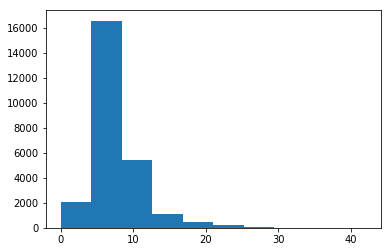

In [14]:
# sequence length analysis

seq_length = []
max_seq_length = 0

for i in train_label:
    seqs = t.texts_to_sequences(i['caption']) # input a list of strings
    for j in seqs:
        seq_length.append(len(j))
        max_seq_length = max(len(j), max_seq_length)
for i in test_label:
    seqs = t.texts_to_sequences(i['caption']) # input a list of strings
    for j in seqs:
        seq_length.append(len(j))
        max_seq_length = max(len(j), max_seq_length)

print ('max_seq_length:', max_seq_length)
plt.hist(seq_length)
plt.show()

In [15]:
for i in train_label:
    seqs = t.texts_to_sequences(i['caption']) # input a list of strings
    seqs = [[vocab_size]+j for j in seqs] # put start symbol <S> at begining
    pad_seqs = pad_sequences(seqs, maxlen=out_length, dtype='int32', padding='post', truncating='post', value=0.0)
    i['seq'] = pad_seqs
for i in test_label:
    seqs = t.texts_to_sequences(i['caption']) # input a list of strings
    seqs = [[vocab_size]+j for j in seqs] # put start symbol <S> at begining
    pad_seqs = pad_sequences(seqs, maxlen=out_length, dtype='int32', padding='post', truncating='post', value=0.0)
    i['seq'] = pad_seqs

In [16]:
X = []
Y = []
for i, ii in enumerate(train_label):
    for j, jj in enumerate(ii['seq']):
        X.append(ii['id'])
        Y.append([i, j])

X = np.array(X)
Y = np.array(Y)
print ('train data', X.shape, 'train target', Y.shape)

train data (24232,) train target (24232, 2)


In [17]:
X_test = []
Y_test = []
for i, ii in enumerate(test_label):
    for j, jj in enumerate(ii['seq']):
        X_test.append(ii['id'])
        Y_test.append([i, j])

X_test = np.array(X_test)
Y_test = np.array(Y_test)
print ('test data', X_test.shape, 'test target', Y_test.shape)

test data (1674,) test target (1674, 2)


## model

In [18]:
from keras.models import Model
from keras.layers import Input, LSTM, Dense, RepeatVector, Dropout, Embedding, Concatenate, Permute, Reshape, merge
from keras.layers.wrappers import TimeDistributed, Bidirectional

In [19]:
cnt = 0
def attention_3d_block(inputs):
    global cnt
    # inputs.shape = (batch_size, time_steps, input_dim)
    input_dim = int(inputs.shape[2])
    TIME_STEPS = int(inputs.shape[1]) if inputs.shape[1] == in_length else out_length
    print (TIME_STEPS, input_dim)
    
    a = Permute((2, 1))(inputs)
    #a = Reshape((input_dim, TIME_STEPS))(a) # this line is not useful. It's just to know which dimension is what.
    a = Dense(TIME_STEPS, activation='softmax')(a)
    #if SINGLE_ATTENTION_VECTOR:
    #a = Lambda(lambda x: K.mean(x, axis=1), name='dim_reduction')(a)
    #a = RepeatVector(input_dim)(a)
    a_probs = Permute((2, 1), name='attention_vec_'+str(cnt))(a)
    output_attention_mul = merge([inputs, a_probs], name='attention_mul_'+str(cnt), mode='mul')
    cnt += 1
    return output_attention_mul

In [20]:
encoder_inputs = Input(shape=(in_length, input_dim), name='encoder_input')
encoder_inputs_attn = attention_3d_block(encoder_inputs)
encoder_inputs_drop = Dropout(drop_rate)(encoder_inputs_attn)#####
encoder = LSTM(latent_dim, return_state=True, name='encoder_lstm')
encoder_outputs, state_h, state_c = encoder(encoder_inputs_drop)


encoder_states = [state_h, state_c]

decoder_inputs = Input(shape=(None, vocab_size+1), name='decoder_input')
#decoder_inputs_attn = attention_3d_block(decoder_inputs)
#e = Embedding(len(embedding_matrix), emb_size, weights=[embedding_matrix], input_length=out_length, trainable=False)(decoder_inputs)
decoder_inputs_drop = Dropout(drop_rate)(decoder_inputs)#####
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True, name='decoder_lstm')
decoder_outputs, _, _ = decoder_lstm(decoder_inputs_drop, initial_state=encoder_states)
#decoder_outputs_attn = attention_3d_block(decoder_outputs)
#decoder_outputs_drop = Dropout(drop_rate)(decoder_outputs)
decoder_dense = Dense(vocab_size+1, activation='softmax', name='softmax_dense')
decoder_outputs = decoder_dense(decoder_outputs)

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])

80 4096
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  app.launch_new_instance()
/usr/local/lib/python3.6/site-packages/keras/legacy/layers.py:458: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)


Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [21]:
from keras.utils import plot_model
plot_model(model, to_file='keras_model.png', show_shapes=True)
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
encoder_input (InputLayer)       (None, 80, 4096)      0                                            
____________________________________________________________________________________________________
permute_1 (Permute)              (None, 4096, 80)      0           encoder_input[0][0]              
____________________________________________________________________________________________________
dense_1 (Dense)                  (None, 4096, 80)      6480        permute_1[0][0]                  
____________________________________________________________________________________________________
attention_vec_0 (Permute)        (None, 80, 4096)      0           dense_1[0][0]                    
___________________________________________________________________________________________

### Next: inference mode (sampling).

1) encode input and retrieve initial decoder state

2) run one step of decoder with this initial state
and a "start of sequence" token as target.
Output will be the next target token

3) Repeat with the current target token and current states

In [22]:
# Define sampling models

encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states
)

In [23]:
plot_model(encoder_model, to_file='encoder_model.png', show_shapes=True)
print ( encoder_model.summary() )

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
encoder_input (InputLayer)       (None, 80, 4096)      0                                            
____________________________________________________________________________________________________
permute_1 (Permute)              (None, 4096, 80)      0           encoder_input[0][0]              
____________________________________________________________________________________________________
dense_1 (Dense)                  (None, 4096, 80)      6480        permute_1[0][0]                  
____________________________________________________________________________________________________
attention_vec_0 (Permute)        (None, 80, 4096)      0           dense_1[0][0]                    
___________________________________________________________________________________________

In [24]:
plot_model(decoder_model, to_file='decoder_model.png', show_shapes=True)
print ( decoder_model.summary() )

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
decoder_input (InputLayer)       (None, None, 6063)    0                                            
____________________________________________________________________________________________________
input_1 (InputLayer)             (None, 256)           0                                            
____________________________________________________________________________________________________
input_2 (InputLayer)             (None, 256)           0                                            
____________________________________________________________________________________________________
decoder_lstm (LSTM)              [(None, None, 256), ( 6471680     decoder_input[0][0]              
                                                                   input_1[0][0]           

In [25]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, vocab_size+1))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, vocab_size] = 1.
    
    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = []
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        # Sample a token
        sampled_index = np.argmax(output_tokens[0, -1, :])
        sampled_word = idx2vocab[sampled_index]
        decoded_sentence.append(sampled_word)

        # Exit condition: either hit max length or find stop character.
        # or sampled_word == '<pad>'
        if (len(decoded_sentence) >= out_length):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, vocab_size+1))
        target_seq[0, 0, sampled_index] = 1.

        # Update states
        states_value = [h, c]

    return decoded_sentence

In [26]:
def decode_sequence_reduce(input_seq):
    states_value = encoder_model.predict(input_seq)
    target_seq = np.zeros((1, 1, vocab_size+1))
    target_seq[0, 0, vocab_size] = 1.
    
    stop_condition = False
    decoded_sentence = []
    last_word = ""
    last_last_word = ""
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        sampled_index = np.argmax(output_tokens[0, -1, :])
        sampled_word = idx2vocab[sampled_index]
        
        if sampled_word == last_word or sampled_word == last_last_word:
            output_tokens[0, -1, sampled_index] = 0
            sampled_index = np.argmax(output_tokens[0, -1, :])
            sampled_word = idx2vocab[sampled_index]
        if sampled_word == last_word or sampled_word == last_last_word:
            output_tokens[0, -1, sampled_index] = 0
            sampled_index = np.argmax(output_tokens[0, -1, :])
            sampled_word = idx2vocab[sampled_index]
        
        last_last_word = last_word
        last_word = sampled_word
        
            
        decoded_sentence.append(sampled_word)

        if (len(decoded_sentence) >= out_length):# or sampled_word == "<pad>":
            stop_condition = True
        

        target_seq = np.zeros((1, 1, vocab_size+1))
        target_seq[0, 0, sampled_index] = 1.

        states_value = [h, c]

    return decoded_sentence

In [27]:
def make_node(state, prob, last, word, idx):
    seq = np.zeros((1, 1, vocab_size+1))
    seq[0, 0, idx] = 1.
    l = 0 if last == None else last['len']+1
    prob = 0 if last == None else prob+last['prob']
    node = {'state':state, 'seq':seq, 'prob':prob, 'last':last, 'len':l, 'word':word, 'idx':idx, 'next':[]}
    return node

In [28]:
def decode_sequence_beam(input_seq):
    states_value = encoder_model.predict(input_seq)
    init_node = make_node(states_value, 0, None, "<S>", vocab_size)
    queue = [init_node]
    leaf_nodes = []
    
    stop_condition = False
    decoded_sentence = []
    
    while len(queue) != 0:
        #print (len(queue), end='\r')
        node = queue[0]
        if node['len'] >= out_length or node['word'] == '<pad>':
            leaf_nodes.append(node)
            queue = [] if len(queue) == 1 else queue[1:]
            break
        target_seq = node['seq']
        states_value = node['state']
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        for j in range(2):
            sampled_index = np.argmax(output_tokens[0, -1, :])
            sampled_word = idx2vocab[sampled_index]
            if sampled_word != node['word']:
                new_node = make_node([h, c], output_tokens[0, -1, sampled_index], node, sampled_word, sampled_index)
                node['next'].append(new_node)
                queue.append(new_node)
            output_tokens[0, -1, sampled_index] = 0
        queue = queue[1:]
    
    # start search
    max_prob = 0
    for node in leaf_nodes:
        tmp = node['prob']/node['len']
        if tmp > max_prob:
            max_prob = tmp
            target_node = node
    
    while target_node['last'] != None:
        decoded_sentence.append(target_node['word'])
        target_node = target_node['last']
    

    return decoded_sentence[::-1]

## bleu

In [29]:
from hw2_1_data.bleu_eval import BLEU

In [30]:
# gen output reduce
def gen_output(data, label, decode):
    with open("output_keras.txt", 'w', encoding='utf-8') as f:
        for i in label:
            input_seq = np.array([data[i['id']]])
            decoded_sentence = decode_sequence_reduce(input_seq)
            #print (decoded_sentence)
            out = []
            last = ""
            for j in decoded_sentence:
                if j == "<S>" or j == last:
                    continue
                elif j == '<pad>':
                    break
                last = j
                out.append(j)
            
                
            out = i['id'] + ',' + " ".join(out) + '\n'
            f.write(out)

#gen_output_reduce(test_data, test_label)
#cal_bleu(test_label)

In [31]:
def cal_bleu(label):
    output = "output_keras.txt"
    result = {}
    with open(output, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.rstrip()
            comma = line.index(',')
            test_id = line[:comma]
            caption = line[comma+1:]
            result[test_id] = caption
    #count by the method described in the paper https://aclanthology.info/pdf/P/P02/P02-1040.pdf
    bleu=[]
    for item in label:
        score_per_video = []
        captions = [x.rstrip('.') for x in item['caption']]
        
        score_per_video.append(BLEU(result[item['id']],captions,True))
        bleu.append(score_per_video[0])
    average = sum(bleu) / len(bleu)
    #print("Average bleu score is " + str(average))
    return average

In [32]:
def show_outputs_and_score(label, n):
    output = "output_keras.txt"
    result = {}
    with open(output, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.rstrip()
            comma = line.index(',')
            test_id = line[:comma]
            caption = line[comma+1:]
            result[test_id] = caption
    #count by the method described in the paper https://aclanthology.info/pdf/P/P02/P02-1040.pdf
    bleu=[]
    for item in label[:n]:
        captions = [x.rstrip('.') for x in item['caption']]
        b = BLEU(result[item['id']],captions,True)
        bleu.append(b)
        print (round(b, 2), result[item['id']])

    average = sum(bleu) / len(bleu)
    #print("Average bleu score is " + str(average))
    print ('avg', average)

## data generators

In [33]:
from keras.utils import to_categorical

In [34]:
def idx2data(idx, x, y, data, label):
    # x[idx] is id, y[idx][0] is label index, y[idx][1] is seq index
    encoder_input = data[x[idx]]
    decoder_input = label[y[idx][0]]['seq'][y[idx][1]]
    decoder_target = np.concatenate((decoder_input[1:], np.array([0], dtype='int32')))
    return encoder_input, decoder_input, decoder_target

In [35]:
def data_generator(data, targets):
    global train_data, train_label, batch_size, voacb_size
    idx = np.arange(len(data))
    while True:
        np.random.shuffle(idx)
        batches = [idx[range(batch_size*i, min(len(data), batch_size*(i+1)))] for i in range(len(data)//batch_size+1)] 
        
        for i in batches:
            encoder_inputs, decoder_inputs, decoder_targets = [], [], []
            for j in i:
                x, y, z = idx2data(j, data, targets, train_data, train_label)
                encoder_inputs.append(x)
                decoder_inputs.append(y)
                decoder_targets.append(z)
            
            encoder_inputs = np.array(encoder_inputs)
            decoder_inputs = to_categorical(decoder_inputs, num_classes=vocab_size+1).reshape(-1, out_length, vocab_size+1)
            decoder_targets = to_categorical(decoder_targets, num_classes=vocab_size+1).reshape(-1, out_length, vocab_size+1)
            yield ([encoder_inputs, decoder_inputs], decoder_targets)

In [36]:
def validation_generator(data, targets):
    global test_data, test_label, batch_size, voacb_size
    idx = np.arange(len(data))
    while True:
        np.random.shuffle(idx)
        batches = [idx[range(batch_size*i, min(len(data), batch_size*(i+1)))] for i in range(len(data)//batch_size+1)] 
        
        for i in batches:
            encoder_inputs, decoder_inputs, decoder_targets = [], [], []
            for j in i:
                x, y, z = idx2data(j, data, targets, test_data, test_label)
                encoder_inputs.append(x)
                decoder_inputs.append(y)
                decoder_targets.append(z)
            
            encoder_inputs = np.array(encoder_inputs)
            decoder_inputs = to_categorical(decoder_inputs, num_classes=vocab_size+1).reshape(-1, out_length, vocab_size+1)
            decoder_targets = to_categorical(decoder_targets, num_classes=vocab_size+1).reshape(-1, out_length, vocab_size+1)
            yield ([encoder_inputs, decoder_inputs], decoder_targets)

## callbacks

In [37]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, Callback

In [38]:
class MyCallback(Callback):
    def __init__(self):
        self.best_score = 0
        self.bleu_history = {'train':[], 'test':[]}
        self.saved_model = ""
        
    def on_epoch_end(self, epoch, logs={}):
        
        gen_output(train_data, train_label, decode_sequence_reduce)
        show_outputs_and_score(train_label, 10)
        try:
            score = cal_bleu(train_label)
            score = round(score, 3)
            self.bleu_history['train'].append(score)
        except ZeroDivisionError:
            return
        print('\nTrain Bleu score: {}'.format(score))
        print ()
        
        gen_output(test_data, test_label, decode_sequence_reduce)
        show_outputs_and_score(test_label, 10)
        try:
            score = cal_bleu(test_label)
            score = round(score, 3)
            self.bleu_history['test'].append(score)
        except ZeroDivisionError:
            return
        print('Test Bleu score: {}\n'.format(score))
        
        if score > self.best_score:
            model.save_weights('model_keras_{}.hdf5'.format(score))
            self.saved_model = 'model_keras_{}.hdf5'.format(score)
            if self.best_score != 0:
                try:
                    os.remove('model_keras_{}.hdf5'.format(self.best_score))
                except Exception as e:
                    print (str(e))
                    print ('model_keras_{}.hdf5'.format(self.best_score), 'not found')
            self.best_score = score

In [39]:
#checkpoint = ModelCheckpoint("model.hdf5", monitor='val_acc', save_best_only=True)
earlystop = EarlyStopping(monitor='val_acc', patience=5)
mycallback = MyCallback()
callbacks_list = [mycallback]

## inference mode training

In [40]:
from keras.layers import Lambda
from keras import backend as K
from keras import optimizers

In [49]:
encoder_outputs, state_h, state_c = encoder(encoder_inputs_drop)
states = [state_h, state_c]
decoder_inputs = Input(shape=(1, vocab_size+1), name='decoer_inputs_inf')


# reinjecting the decoder's predictions into the decoder's input, just like we were doing for inference.
all_outputs = []
inputs = decoder_inputs

for _ in range(out_length):
    # Run the decoder on one timestep
    outputs, state_h, state_c = decoder_lstm(inputs, initial_state=states)
    outputs = decoder_dense(outputs) ## softmax
    argmax_outputs = Lambda(lambda x: K.one_hot(K.argmax(x, axis=2), vocab_size+1))(outputs)
    # Store the current prediction (we will concatenate all predictions later)
    all_outputs.append(outputs)
    # Reinject the outputs as inputs for the next loop iteration
    # as well as update the states
    inputs = argmax_outputs
    states = [state_h, state_c]

decoder_outputs = Lambda(lambda x: K.concatenate(x, axis=1))(all_outputs)

opt = optimizers.RMSprop(lr=0.0001)
model_inf = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model_inf.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['acc'])
model_inf.summary()
plot_model(model, to_file='keras_model_inf.png', show_shapes=True)

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
encoder_input (InputLayer)       (None, 80, 4096)      0                                            
____________________________________________________________________________________________________
permute_1 (Permute)              (None, 4096, 80)      0           encoder_input[0][0]              
____________________________________________________________________________________________________
dense_1 (Dense)                  (None, 4096, 80)      6480        permute_1[0][0]                  
____________________________________________________________________________________________________
attention_vec_0 (Permute)        (None, 80, 4096)      0           dense_1[0][0]                    
___________________________________________________________________________________________

#### Prepare decoder input data that just contains the start character

decoder_input_data = np.zeros((num_samples, 1, num_decoder_tokens))

decoder_input_data[:, 0, target_token_index['\t']] = 1.

In [42]:
def idx2inf_data(idx, x, y, data, label):
    # x[idx] is id, y[idx][0] is label index, y[idx][1] is seq index
    encoder_input = data[x[idx]]
    decoder_input = label[y[idx][0]]['seq'][y[idx][1]]
    decoder_target = np.concatenate((decoder_input[1:], np.array([0], dtype='int32')))
    return encoder_input, decoder_input[0], decoder_target

In [43]:
def inf_data_generator(data, targets):
    global train_data, train_label, batch_size, voacb_size
    idx = np.arange(len(data))
    while True:
        np.random.shuffle(idx)
        batches = [idx[range(batch_size*i, min(len(data), batch_size*(i+1)))] for i in range(len(data)//batch_size+1)] 
        
        for i in batches:
            encoder_inputs, decoder_inputs, decoder_targets = [], [], []
            for j in i:
                x, y, z = idx2inf_data(j, data, targets, train_data, train_label)
                encoder_inputs.append(x)
                decoder_inputs.append(y)
                decoder_targets.append(z)
            
            encoder_inputs = np.array(encoder_inputs)
            decoder_inputs = to_categorical(decoder_inputs, num_classes=vocab_size+1).reshape(-1, 1, vocab_size+1)
            decoder_targets = to_categorical(decoder_targets, num_classes=vocab_size+1).reshape(-1, out_length, vocab_size+1)
            #decoder_targets = np.expand_dims(decoder_targets, axis=1)
            #print (encoder_inputs.shape, decoder_inputs.shape, decoder_targets.shape)
            yield ([encoder_inputs, decoder_inputs], decoder_targets)

In [44]:
def inf_validation_generator(data, targets):
    global test_data, test_label, batch_size, voacb_size
    idx = np.arange(len(data))
    while True:
        np.random.shuffle(idx)
        batches = [idx[range(batch_size*i, min(len(data), batch_size*(i+1)))] for i in range(len(data)//batch_size+1)] 
        
        for i in batches:
            encoder_inputs, decoder_inputs, decoder_targets = [], [], []
            for j in i:
                x, y, z = idx2inf_data(j, data, targets, test_data, test_label)
                encoder_inputs.append(x)
                decoder_inputs.append(y)
                decoder_targets.append(z)
            
            encoder_inputs = np.array(encoder_inputs)
            decoder_inputs = to_categorical(decoder_inputs, num_classes=vocab_size+1).reshape(-1, 1, vocab_size+1)
            decoder_targets = to_categorical(decoder_targets, num_classes=vocab_size+1).reshape(-1, out_length, vocab_size+1)
            #decoder_targets = np.expand_dims(decoder_targets, axis=1)
            yield ([encoder_inputs, decoder_inputs], decoder_targets)

## Train

In [45]:
metrics = ['loss', 'val_loss', 'acc', 'val_acc']
myhistory = {i:[] for i in metrics}

In [ ]:
# pretrain
history = model.fit_generator(data_generator(X, Y), steps_per_epoch=int((len(Y)+batch_size-1)/batch_size), 
                                      validation_data=validation_generator(X_test, Y_test), 
                                      validation_steps=int((len(Y_test)+batch_size-1)/batch_size),
                                      epochs=15, callbacks=callbacks_list)

Epoch 1/15
757/758 [============================>.] - ETA: 0s - loss: 1.5970 - acc: 0.73281.0 a woman is walking a horse
0.86 a man is pouring into a bowl
1.0 a loris is eating a food
1.0 a person is seasoning eggs
0.8 a person is cutting a
0.83 a are is running a the
1.0 a man is talking
0.83 a woman is peeling a garlic
1.0 a man is doing
1.0 a man is doing ups
avg 0.9323809523809523

Train Bleu score: 0.927

0.83 a man is peeling a of
0.5 a man is shooting a water
0.83 a man is doing a on
0.67 a man is playing a toy
0.8 a man is a on
0.5 a dog is eating a from
0.83 a baby is eating a baby
0.29 a panda is walking on a snow
0.67 a man is doing on a
0.83 a man is putting a box
avg 0.6752380952380952
Test Bleu score: 0.684

758/758 [==============================] - 220s - loss: 1.5970 - acc: 0.7328 - val_loss: 1.7403 - val_acc: 0.7173
Epoch 2/15
757/758 [============================>.] - ETA: 0s - loss: 1.3733 - acc: 0.75690.83 a woman is a woman horse
1.0 a man is cutting butter into a

In [50]:
history = model_inf.fit_generator(inf_data_generator(X, Y), 
                                  steps_per_epoch=int((len(Y)+batch_size-1)/batch_size), 
                                  validation_data=inf_validation_generator(X_test, Y_test), 
                                  validation_steps=int((len(Y_test)+batch_size-1)/batch_size),
                                  epochs=15, 
                                  callbacks=callbacks_list)

Epoch 1/15
757/758 [============================>.] - ETA: 0s - loss: 2.7090 - acc: 0.65700.45 a man is a
0.78 a man is a
0.75 a man is a
1.0 a man is a
0.75 a man is a
0.75 a man is a
1.0 a man is a
0.58 a man is a
1.0 a man is a
0.78 a man is a
avg 0.7846600148230838

Train Bleu score: 0.714

0.78 a man is a
0.75 a man is a
1.0 a man is a
0.58 a man is a
1.0 a man is a
0.58 a man is a
0.58 a man is a
0.0 a man is a
0.58 a man is a
0.78 a man is a
avg 0.6644003915357024
Test Bleu score: 0.696

758/758 [==============================] - 239s - loss: 2.7083 - acc: 0.6570 - val_loss: 2.2347 - val_acc: 0.6942
Epoch 2/15
757/758 [============================>.] - ETA: 0s - loss: 2.1220 - acc: 0.69570.65 a man is a the
1.0 a man is a the
0.8 a man is a the
1.0 a man is a the
0.8 a man is a the
0.8 a man is a the
1.0 a man is a the
0.58 a man is a
1.0 a man is a the
1.0 a man is a the
avg 0.8639085189765939

Train Bleu score: 0.807

1.0 a man is a the
0.65 a man is a the
1.0 a man is a
0.8 a

758/758 [==============================] - 232s - loss: 1.6904 - acc: 0.7257 - val_loss: 2.0084 - val_acc: 0.6987
Epoch 13/15
757/758 [============================>.] - ETA: 0s - loss: 1.6684 - acc: 0.72740.83 a woman is a woman and
1.0 a man is a into
1.0 a animal is eating a
1.0 a man is adding a
1.0 a person is a on
0.75 two are of a
1.0 a man is talking
1.0 a woman is peeling a
1.0 a man is doing a
1.0 a man is doing a
avg 0.9583333333333334

Train Bleu score: 0.93

1.0 a man is a the
0.65 a woman is a the
0.83 a man is doing a on
0.8 a baby is playing a
1.0 a man is a the
0.8 a dog is a the
1.0 a baby is a on
0.4 a panda is playing a
0.67 a man is doing a on
1.0 a man is a the of a
avg 0.8154984602462386
Test Bleu score: 0.774

758/758 [==============================] - 232s - loss: 1.6689 - acc: 0.7273 - val_loss: 2.0301 - val_acc: 0.6995
Epoch 14/15
757/758 [============================>.] - ETA: 0s - loss: 1.6477 - acc: 0.72901.0 a woman is a the on
1.0 a man is a into
1.0 a an

In [ ]:
for i in metrics:
    myhistory[i].append(history.history[i][-1])

In [57]:
gen_output(test_data, test_label, decode_sequence_reduce)
cal_bleu(test_label)

0.6939950765347153

In [ ]:
teacher_force_ratio = 100
epochs = 3

In [ ]:
for epoch in range(epochs):
    print ('epoch', epoch)
    try:
        #if np.random.random() < teacher_force_ratio:
        print ('teacher forcing')
        history = model.fit_generator(data_generator(X, Y), steps_per_epoch=int((len(Y)+batch_size-1)/batch_size), 
                                      validation_data=validation_generator(X_test, Y_test), 
                                      validation_steps=int((len(Y_test)+batch_size-1)/batch_size),
                                      epochs=1, callbacks=callbacks_list)
        #else:
        print ('inference mode')
        history = model_inf.fit_generator(inf_data_generator(X, Y), 
                                          steps_per_epoch=int((len(Y)+batch_size-1)/batch_size), 
                                          validation_data=inf_validation_generator(X_test, Y_test), 
                                          validation_steps=int((len(Y_test)+batch_size-1)/batch_size),
                                          epochs=1, 
                                          callbacks=callbacks_list)
    except KeyboardInterrupt:
        print ('KeyboardInterrupt')
        break
        
    for i in metrics:
        myhistory[i].append(history.history[i][-1])
        
    #if (epoch+1)%4 == 0:
    #    teacher_force_ratio -= 0.1

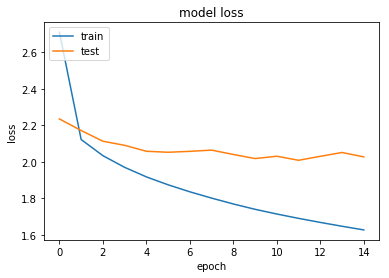

In [51]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

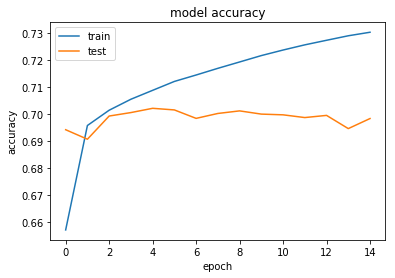

In [52]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

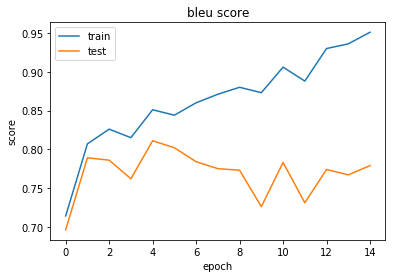

In [53]:
plt.plot(mycallback.bleu_history['train'])
plt.plot(mycallback.bleu_history['test'])
plt.title('bleu score')
plt.ylabel('score')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()

In [ ]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(history.history['loss'], label='loss', c='b')
ax1.plot(history.history['val_loss'], label='val_loss', c='b', linestyle='--')
ax1.set_ylabel('loss')
#ax1.legend(['loss', 'val_loss'])


ax2.plot(mycallback.bleu_history['train'], label='bleu', c='r')
ax2.plot(mycallback.bleu_history['test'], label='val_bleu', c='r', linestyle='--')
ax2.set_ylabel('bleu score')

plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()

In [ ]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(history.history['acc'], label='acc', c='b')
ax1.plot(history.history['val_acc'], label='val_acc', c='b', linestyle='--')
ax1.set_ylabel('accuracy')

ax2.plot(mycallback.bleu_history['train'], label='bleu', c='r')
ax2.plot(mycallback.bleu_history['test'], label='val_bleu', c='r', linestyle='--')
ax2.set_ylabel('bleu score')

plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()

In [50]:
model.save('model_0.694.hdf5')

In [54]:
print (mycallback.saved_model, mycallback.best_score)

model_keras_0.811.hdf5 0.811


In [52]:
from keras.models import load_model
model2 = load_model('model_0.694.hdf5')

/usr/local/lib/python3.6/site-packages/keras/engine/topology.py:1252: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  return cls(**config)


In [55]:
model.load_weights('model_keras_0.694.hdf5')

In [ ]:
gen_output(test_data, test_label, decode_sequence_beam)
cal_bleu(test_label)

In [ ]:
show_outputs_and_score(test_label, 20)

In [ ]:
import nltk
#nltk.download('averaged_perceptron_tagger')

In [ ]:
def decode_sequence_reduce_2(input_seq):
    states_value = encoder_model.predict(input_seq)
    target_seq = np.zeros((1, 1, vocab_size+1))
    target_seq[0, 0, vocab_size] = 1.
    
    stop_condition = False
    decoded_sentence = []
    last_word = ""
    last_last_word = ""
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        sampled_index = np.argmax(output_tokens[0, -1, :])
        sampled_word = idx2vocab[sampled_index]
        
        if sampled_word == last_word or sampled_word == last_last_word:
            output_tokens[0, -1, sampled_index] = 0
            sampled_index = np.argmax(output_tokens[0, -1, :])
            sampled_word = idx2vocab[sampled_index]
        if sampled_word == last_word or sampled_word == last_last_word:
            output_tokens[0, -1, sampled_index] = 0
            sampled_index = np.argmax(output_tokens[0, -1, :])
            sampled_word = idx2vocab[sampled_index]
        
        last_last_word = last_word
        last_word = sampled_word
            
        
        
        if (len(decoded_sentence) >= out_length) or sampled_word == "<pad>":
            tag = nltk.pos_tag([last_last_word])[0][1]
            if  tag == 'DT' or tag == 'IN':
                #decoded_sentence.append('!')
                while True:
                    output_tokens[0, -1, sampled_index] = 0
                    sampled_index = np.argmax(output_tokens[0, -1, :])
                    sampled_word = idx2vocab[sampled_index]
                    if nltk.pos_tag([sampled_word])[0][1] == 'NN':
                        decoded_sentence.append(sampled_word)
                        break
            stop_condition = True
            continue
            
        decoded_sentence.append(sampled_word)

        target_seq = np.zeros((1, 1, vocab_size+1))
        target_seq[0, 0, sampled_index] = 1.

        states_value = [h, c]

    return decoded_sentence

In [ ]:
for i in test_label[:20]:
    input_seq = np.array([test_data[i['id']]])
    decoded_sentence = decode_sequence_reduce_2(input_seq)
    print (i['caption'][0])
    print (decoded_sentence)

In [ ]:
with open("output_keras.txt", 'w', encoding='utf-8') as f:
    for i in test_label:
        input_seq = np.array([test_data[i['id']]])
        decoded_sentence = decode_sequence_reduce_2(input_seq)
        #print (decoded_sentence)
        out = []
        last = ""
        for j in decoded_sentence:
            if j == '<pad>' or j == "<S>" or j == last:
                continue
            last = j
            out.append(j)


        out = i['id'] + ',' + " ".join(out) + '\n'
        f.write(out)
    
cal_bleu(test_label)